# Does Snow Depth influence SWESARR Radar Backscatter?

### Contributor: Nani Ciafone

To answer the above question, we look at the relationship between SWESARR radar backscatter and airborne LiDAR-derived snow depth using datasets collected as part of SnowEx 2020 at Grand Mesa, CO.  

* SWESARR radar was collected on February 11, 2020 and February 12, 2020
* We aimed to leverage a snowdepth raster that was collected as close to the above dates as possible. Therefore, we selected LiDAR collected on February 13, 2020

    


In [7]:
#Install necessary packages for data download, transformations, and visualization 

from snowexsql.api import PointMeasurements, LayerMeasurements, RasterMeasurements
from datetime import datetime 
import rasterio 
import rioxarray as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
import xarray
import pandas as pd
from pyproj import CRS
import os 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, Polygon

#Store SWESARR file path as a variable
swesarr_file_path= "/home/jovyan/shared-public/swesarr project!/swesarr-radar/GRMST1_27702_20007_009_200211_225_XX_01/GRMST1_27702_20007_009_200211_09225VV_XX_01.tif"

In [8]:
# Store LiDAR date as a variable
dt = datetime(2020, 2, 13)

# Query db filtering to swe on a certain date surveyed by ASO
ds = RasterMeasurements.from_filter(observers='ASO Inc.', date=dt, type='depth')


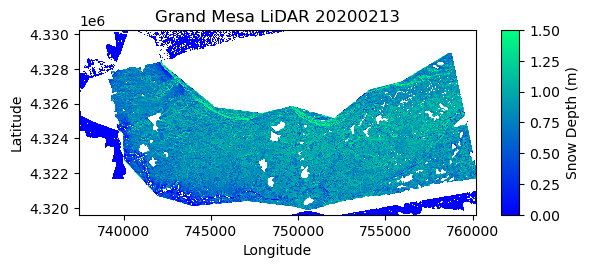

In [9]:
#Plot LiDAR data. Constrain min and max values so that color ramp is not washed out by variables.

# Create the raster plot
dataset = ds[0]  # Access the DatasetReader
# Read the first band into a NumPy array
raster_data = dataset.read(1)
# Get the affine transform
transform = dataset.transform

#Build extent with transform
extent = (transform[2], 
          transform[2] + dataset.width * transform[0], 
          transform[5] + dataset.height * transform[4], 
          transform[5])

# Create the raster plot
img = plt.imshow(raster_data,  vmin=0, vmax=1.5, cmap='winter', interpolation='none', extent = extent)

# Label the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(img, label='Snow Depth (m)', shrink=0.5, aspect=10)
plt.title('Grand Mesa LiDAR 20200213')

# Show the plot
plt.show()

In [17]:
# ##Now, we need to see if the resolutions and CRS of the SWESARR and LiDAR are the same 
SWESARR = rio.open_rasterio(swesarr_file_path)
swesarr_data = SWESARR[0]

print("LiDAR resolution:", ds[0].res)
print("LiDAR CRS:", ds[0].crs)
print("SWESARR resolution:", swesarr_data.res)
print("SWESARR CRS:", swesarr_data.crs)

LiDAR resolution: (3.000000000007304, 3.000000000007304)
LiDAR CRS: EPSG:26912


AttributeError: 'DataArray' object has no attribute 'res'

In [16]:
##CRS are the same, resolution is not
##use rasterio to resample SWESARR

# Write DB raster to file
with rasterio.open("snow_depth_200213.tif", "w", **ds[0].profile) as dst:
    dst.write(ds[0].read(1), 1)

# Open as a DataArray
LiDAR = rio.open_rasterio("/home/jovyan/swesarr/swesarr/contributors/naniciafone/snow_depth_200213.tif")

# Open SWESARR as data array
SWESARR = rio.open_rasterio(swesarr_file_path)

# Reproject and match resolution
SWESARR_match = SWESARR.rio.reproject_match(LiDAR)

# Double check resolution and CRS
print("LiDAR resolution:", LiDAR.rio.resolution())
print("LiDAR CRS:", LiDAR.rio.crs)
print("SWESARR resolution:", SWESARR_match.rio.resolution())
print("SWESARR CRS:", SWESARR_match.rio.crs)

LiDAR resolution: (3.000000000007304, -3.000000000007304)
LiDAR CRS: EPSG:26912
SWESARR resolution: (3.0000000000073, -3.0000000000073936)
SWESARR CRS: EPSG:26912


In [18]:
#Now, we need to clip the LiDAR to the radar AOI. We have an AOI shapefile for this. 

##To start, pull AOI shapefile into environment. This will be used to clip LiDAR. We will call it in as a geopandas read file. 
gdf = gpd.read_file("/home/jovyan/swesarr/swesarr/swesarr-roi.shp")

#Look at crs of shapefile and LiDAR
print("LiDAR CRS:", LiDAR.rio.crs)
print("Shapefile CRS:", gdf.crs)

LiDAR CRS: EPSG:26912
Shapefile CRS: EPSG:4326


In [146]:
#Need to tranform crs!
#transform 
gdf_transform = gdf.to_crs(epsg=26912)
# Check the new CRS
print("Transformed CRS:", gdf_transform.crs)

Transformed CRS: EPSG:26912


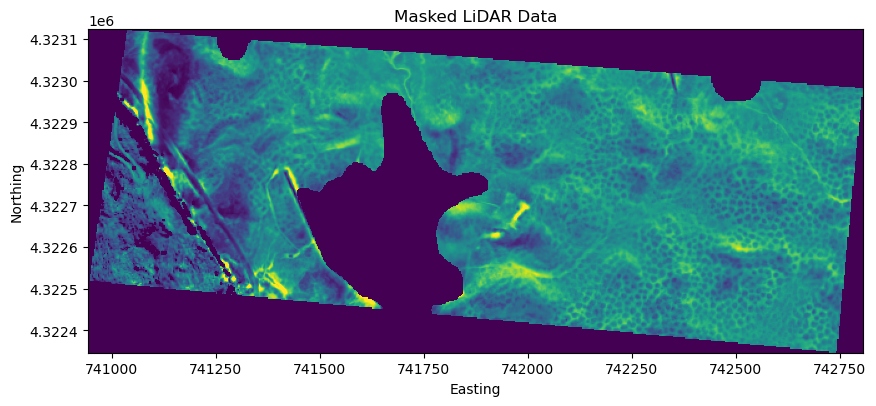

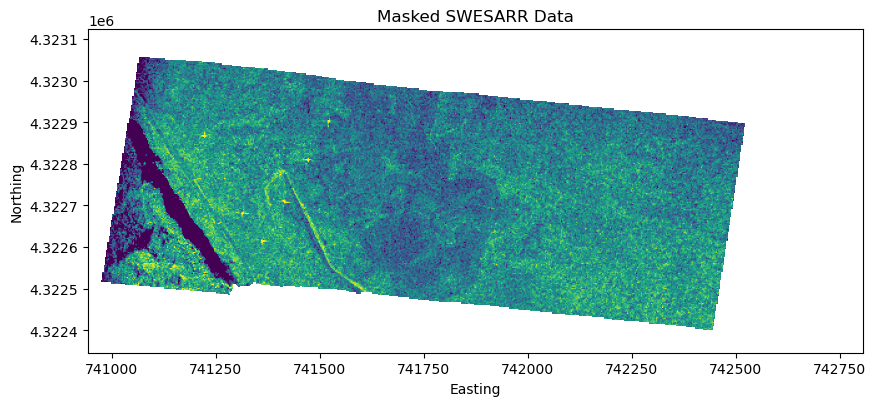

In [178]:
#Mask with transformed shp (gdf_transform)

##Mask and Plot LiDAR
geometries = gdf_transform.geometry.tolist()

LiDAR_clipped = LiDAR.rio.clip(geometries, drop=True)

# Get the affine transform
LiDAR_transform = LiDAR_clipped.rio.transform()

# Convert the DataArray to a numpy array for rasterio.plot.show
LiDAR_np = LiDAR_clipped[0].values  # Convert the first band to a numpy array

# Plot the masked data with rasterio
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(LiDAR_np, transform=LiDAR_transform, ax=ax, cmap='viridis', vmin=0.001, vmax=1.5)
ax.set_title('Masked LiDAR Data')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
plt.show()

###Mask and Plot SWESARR

SWESARR_clipped = SWESARR_match.rio.clip(geometries, drop=True)

# Get the affine transform
SWESARR_transform = SWESARR_clipped.rio.transform()

# Convert the DataArray to a numpy array for rasterio.plot.show
SWESARR_np = SWESARR_clipped[0].values  # Convert the first band to a numpy array
SWESARR_np[SWESARR_np == 0 ] = np.nan

# Plot the masked data with rasterio
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(SWESARR_np, transform=SWESARR_transform, ax=ax, cmap='viridis', vmin=-25, vmax=-5)
ax.set_title('Masked SWESARR Data')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
plt.show()


In [162]:
##Start Building AOI
#coordinate = -108.2017, 39.0193
##Found this through Dylan's graph. Found a point that looked like it 
ptlat = 39.0193
ptlong = -108.2017

from pyproj import Transformer

# Convert latitude and longitude to UTM
wgs84_crs = "EPSG:4326"
utm_crs   = "EPSG:32612"
trnsfmr             = Transformer.from_crs(wgs84_crs, utm_crs)
rad_east, rad_north = trnsfmr.transform(ptlat, ptlong)
print(rad_east, rad_north)


742264.0302178229 4322644.604861974


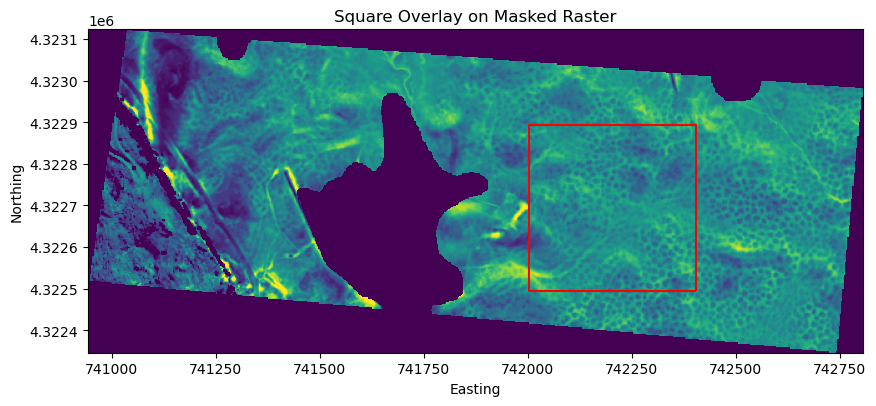

In [197]:
#Build new AOI around point 742264.0302178229 4322644.604861974

# Step 1: Define the square's coordinates
x_center = 742204.0302178229
y_center = 4322694.604861974
offset = 200  # 50 meters in each direction

# Create the square
minx = x_center - offset
maxx = x_center + offset
miny = y_center - offset
maxy = y_center + offset

square_geom = box(minx, miny, maxx, maxy)
gdf_square = gpd.GeoDataFrame([1], geometry=[square_geom], crs="EPSG:26911")  # NAD83 / UTM zone 11N

##Plot

# Show the masked raster data
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(LiDAR_np, transform=LiDAR_transform, ax=ax, cmap='viridis', vmin=0.001, vmax=1.5)
ax.set_title('Masked LiDAR Data')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
# Plot the square on the raster
gdf_square.boundary.plot(ax=ax, color='red')

# Set the title and display the plot
ax.set_title('Square Overlay on Masked Raster')
plt.show()


                           points
0  POINT (742358.085 4322597.057)
1  POINT (742084.266 4322580.195)
2   POINT (742061.65 4322720.033)
3  POINT (742288.917 4322742.845)
4     POINT (742016.3 4322586.17)


<Axes: >

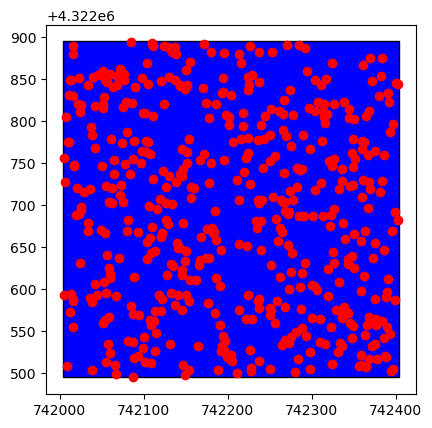

In [198]:
#Create random points in polygon

def Random_Points_in_Bounds(polygon, number):   
    min_x, min_y, max_x, max_y = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

#Now, let’s create another GeoDataFrame with random points in the bounding box of our polygon.
x,y = Random_Points_in_Bounds(gdf_square, 500)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')

print(gdf_points.head())
ax = gdf_square.plot(color='blue', edgecolor='black')
gdf_points.plot(ax=ax, color='red')

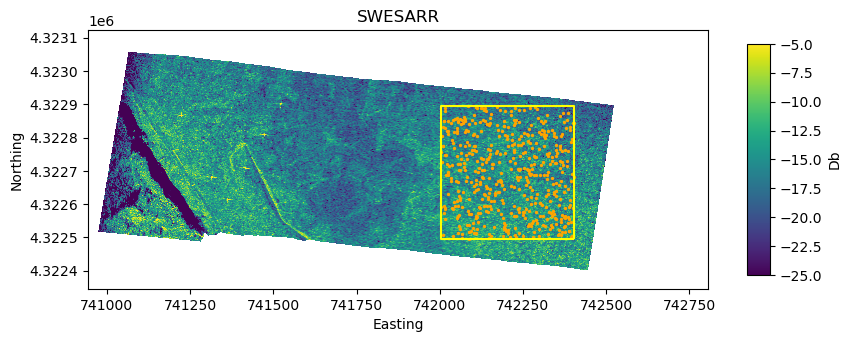

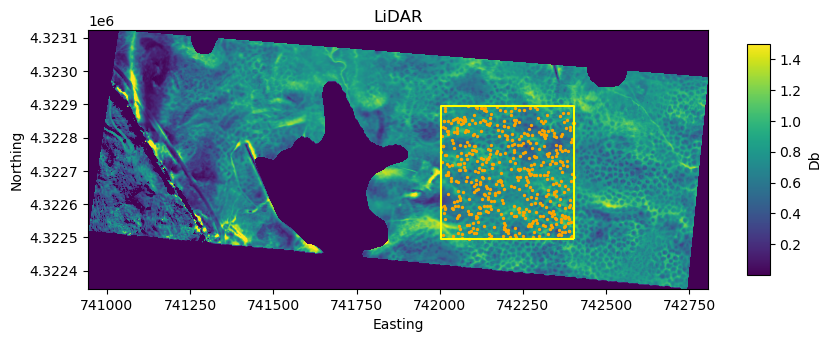

In [214]:
##Plot

##SWESARR
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data
image = rasterio.plot.show(SWESARR_np, transform=SWESARR_transform, ax=ax, cmap='viridis', vmin=-25, vmax=-5)

# Add the colorbar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Db')  # Set a label for the color bar

# Set the title and labels
ax.set_title('SWESARR')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')

# Plot the boundaries and points
gdf_square.boundary.plot(ax=ax, color='yellow')
gdf_points.plot(ax=ax, color='orange', markersize=2)

# Display the plot
plt.show()


##############################################
##Look at LiDAR too
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data
image = rasterio.plot.show(LiDAR_np, transform=LiDAR_transform, ax=ax, cmap='viridis', vmin=0.0001, vmax=1.5)

# Add the colorbar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Db')  # Set a label for the color bar

# Set the title and labels
ax.set_title('LiDAR')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')

# Plot the boundaries and points
gdf_square.boundary.plot(ax=ax, color='yellow')
gdf_points.plot(ax=ax, color='orange', markersize=2)

# Display the plot
plt.show()